In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix

In [104]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [4]:
engage = pd.read_csv('takehome_user_engagement.csv')

In [16]:
print(engage.info())
engage.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Data Wrangling

In [59]:
# set up "adopted user" variable

# convert 'time_stamp' to datetime
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])

# sort by date and user id
engage = engage.sort_values(by=['user_id','day'])

# create function to count visits in a 7 day window
def rolling_count(df, freq):
    return df.rolling(freq, on='time_stamp')['visited'].count()

# apply function
engage['active'] = engage.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, freq='7D')

In [95]:
# find users who visited 3 or more times in a 7 day period
adopted_users = engage.loc[(engage['active'] >= 3)]
adopted_users.head()

,time_stamp,user_id,visited,day,active
9,2014-02-09 03:45:04,2,1,2014-02-09,3.0
10,2014-02-13 03:45:04,2,1,2014-02-13,3.0
27,2013-02-19 22:08:03,10,1,2013-02-19,3.0
30,2013-03-02 22:08:03,10,1,2013-03-02,3.0
31,2013-03-05 22:08:03,10,1,2013-03-05,3.0


In [197]:
# count unique users - this is the number of adopted users
print("Adopted users:",len(adopted_users['user_id'].unique()))
print(len(users['object_id'].unique()))

Adopted users: 1602
12000


In [198]:
print("The proportion of users that are considered adopted is:", round(1602/12000, 3))

The proportion of users that are considered adopted is: 0.134


In [194]:
# classify original users as adopted or not

users['adopted'] = users['object_id'].isin(adopted_users['user_id'].unique())
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,referral_count
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,0.0


In [207]:
# create referral count feature 
user_refs = pd.DataFrame(users.invited_by_user_id.value_counts()).reset_index()
user_refs.rename(columns={'index':'object_id','invited_by_user_id':'referral_count'},inplace=True)

In [208]:
# merge
users = users.merge(user_refs, how='left',on='object_id')
users['referral_count'].fillna(0, inplace=True)

In [209]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,referral_count
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,0.0


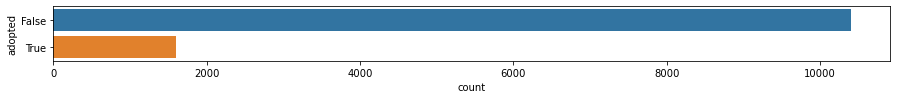

In [210]:
# check class size for target variable, 'adopted'
fig = plt.figure(figsize=(15,1)) 
sns.countplot(y="adopted", data=users);

In [148]:
# overview of the variables
users.profile_report()

In [211]:
# check for nulls
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  adopted                     12000 non-null  bool   
 11  referral_count              12000 non-null  float64
dtypes: bool(1), float64(3), int64(4), object(4)
memory usage: 1.4+ MB


In [169]:
# fill NA
users = users.fillna(0)

In [212]:
# subset data frame for model
users_mod = users.drop(columns=['object_id','creation_time','name','email'])
users_mod = pd.get_dummies(users_mod)

In [213]:
users_mod.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,referral_count,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1,0,11,10803.0,False,0.0,1,0,0,0,0
1,1.396238e+09,0,0,1,316.0,True,0.0,0,1,0,0,0
2,1.363735e+09,0,0,94,1525.0,False,1.0,0,1,0,0,0
3,1.369210e+09,0,0,1,5151.0,False,0.0,1,0,0,0,0
4,1.358850e+09,0,0,193,5240.0,False,0.0,1,0,0,0,0


### Modeling

I first ran a logistic regression, but this model classified all customers as not adopted. I then ran a decision tree, as shown below.

In [ ]:
# define variables
X = users_mod.drop(columns=['adopted'])
y = users_mod['adopted']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=16)

# initiate model 
tree = DecisionTreeClassifier(random_state=16)

# Fit the model 
tree.fit(X_train, y_train)

#predict
y_pred = tree.predict(X_test)

In [218]:
# evaluate model 
print("The f1 score is:",f1_score(y_test, y_pred))
print("The precision score is:",precision_score(y_test, y_pred))
print("The recall score is:",recall_score(y_test, y_pred))

The f1 score is: 0.6065057712486883
The precision score is: 0.6175213675213675
The recall score is: 0.5958762886597938


In [222]:
print(tree.tree_.max_depth)

28


In [230]:
# tuning tree depth

accuracy = {}
precision = []
recall = []
labels = []

for i in range(3,18):
    tree = DecisionTreeClassifier(max_depth=i, random_state=16)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracy[i] = accuracy_score(y_test, y_pred)
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    labels.append(i)

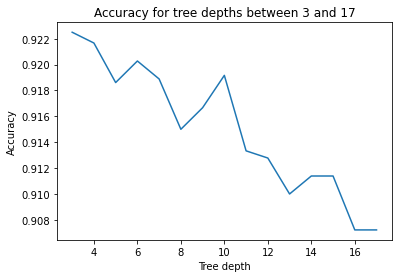

In [231]:
lists = accuracy.items() 

x, y = zip(*lists) 

plt.plot(x, y)
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.title('Accuracy for tree depths between 3 and 17')
plt.show();

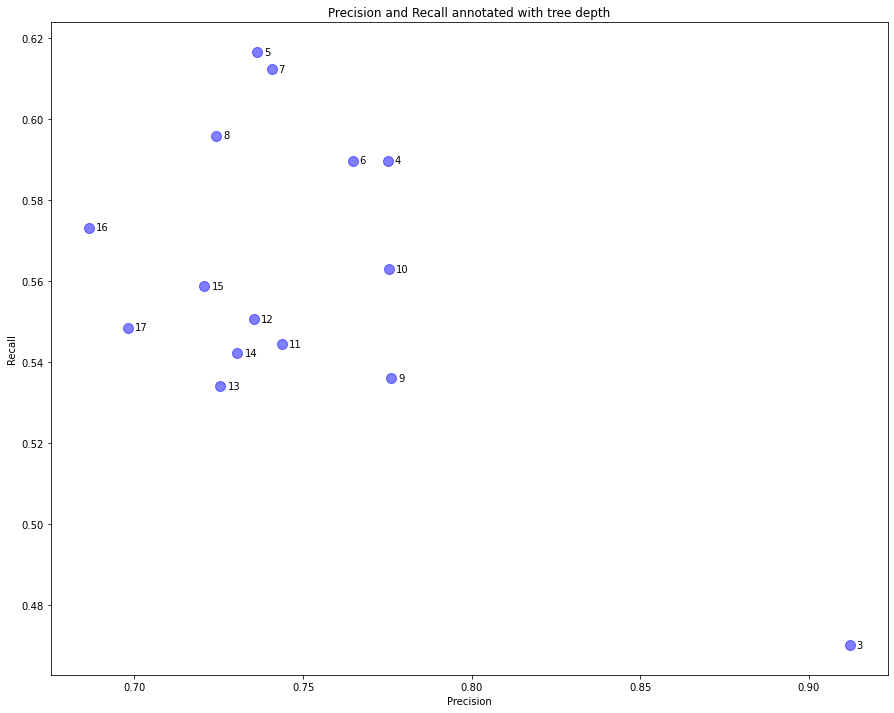

In [232]:
fig, ax = plt.subplots(1, figsize=(15, 12))

x = precision
y = recall


# Plot the scatter points
ax.scatter(x, y,
           color="blue",  # Color of the dots
           s=100,         # Size of the dots
           alpha=0.5,     # Alpha of the dots
           linewidths=1)  # Size of edge around the dots

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(7, 0),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center')       # Vertical alignment is centered

# Show the plot
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision and Recall annotated with tree depth')
plt.show();

In [235]:
# a tree depth of 4 looks like it will be the best option

# initiate model 
tree_4 = DecisionTreeClassifier(random_state=16, max_depth=4)

# Fit the model 
tree_4.fit(X_train, y_train)

#predict
y_pred = tree_4.predict(X_test)

In [236]:
# evaluate model 
print("The f1 score is:",f1_score(y_test, y_pred))
print("The precision score is:",precision_score(y_test, y_pred))
print("The recall score is:",recall_score(y_test, y_pred))

The f1 score is: 0.6697892271662763
The precision score is: 0.7750677506775068
The recall score is: 0.5896907216494846


Confusion matrix without normalization
[[3032   83]
 [ 199  286]]
Normalized confusion matrix
[[0.97335474 0.02664526]
 [0.41030928 0.58969072]]


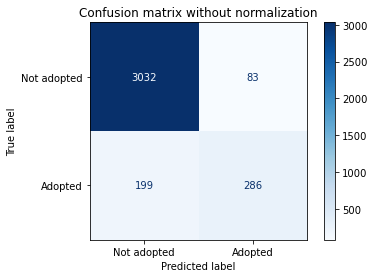

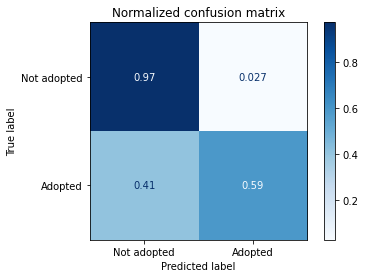

In [237]:
# Plot confusion matrix
titles_options = [("Confusion matrix without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(tree_4, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 display_labels=['Not adopted', 'Adopted'],
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show();

11


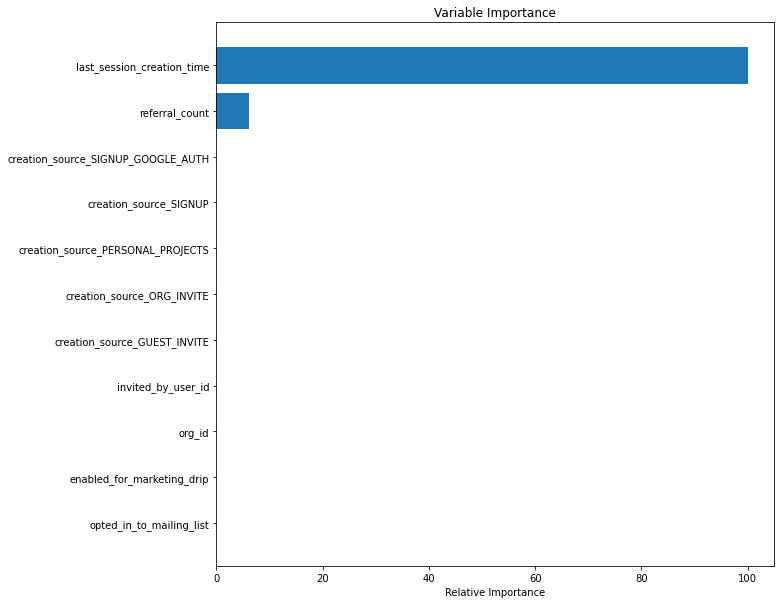

In [245]:
# visualizing feature importance
feat_importance = tree_4.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feat_importance / feat_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The user's last login seems most important in determining if the user is adopted or not. Referral count also plays an important role. This makes sense, as users who like the product enough to refer friends are likely to be using the product themselves. <br>
Further avenues of investigation include:
<li> Does being referred increase the chance of a user becoming adopted?
    <li> Do adopted users and non-adopted users have noticeably different first weeks that might be impacting whether or not they use the product again?
     <li> Are there non-adopted users who are still using the app regularly? Perhaps they are logging in only once a week, but do log in weekly.